In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
from shutil import copy,SameFileError
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# from qiskit_ibm_provider import IBMProvider

from quantum.Quantum import QuantumRegressor
from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import InconsistentVersionWarning

In [2]:
HOME=os.path.expanduser("~")

In [3]:
datadirs=glob('*/A2_HWE-CNOT/A2_HWE-CNOT_results.json')+[os.path.join(HOME,'qregress/qml_DDCC/5/A2_HWE-CNOT/A2_HWE-CNOT_results.json')]

In [4]:
dfs=[]
for i in datadirs:
    with open(i,'r') as g:
        data = json.load(g)
    df = pd.DataFrame.from_dict(data)
    name = os.path.basename(os.path.dirname(os.path.dirname(i)))
    if "RUD"  in name:
        df['RUD']=int(name.replace("RUD",""))
        df['AL']=1
        # df['RUD'] = 
    elif "AL" in name:
        df['RUD']=1
        df['AL']=name.replace("AL","")
    else:
        df['RUD']=1
        df['AL']=1
    dfs.append(df)
    
stacked = pd.concat(dfs)

In [5]:
stacked

,MSE_train,R2_train,MAE_train,MSE_test,R2_test,MAE_test,RUD,AL
0,0.000089,0.772462,0.007630,0.000088,0.773425,0.007602,1,5
0,0.000060,0.846314,0.005351,0.000059,0.847447,0.005359,3,1
0,0.000070,0.821199,0.006070,0.000067,0.826484,0.005983,5,1
0,0.000112,0.712055,0.006330,0.000111,0.714193,0.006314,1,3
0,0.000148,0.619124,0.005974,0.000148,0.618428,0.005966,1,1


In [6]:


# device='qiskit.aer'
# device_backend = FakeCairoV2()
# backend = AerSimulator.from_backend(device_backend)
# device = qml.device(device, wires=num_qubits, backend=backend, shots=shots)


# device='qulacs.simulator'
device='default.qubit'
num_qubits=5
device = qml.device(device, wires=num_qubits)


In [7]:
def circuit(features, parameters):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    for i in range(re_upload_depth):
        params = initial_parameters.reshape(re_upload_depth,-1)[i]
        
        encoder(features, wires=range(num_qubits))
        variational(params, wires=range(num_qubits))

    return qml.expval(qml.PauliZ(0))

In [8]:
def get_depth(enc,var,rud,features,parameters):
    circuit_gates=0
    circuit_depth=0
    for i in range(rud):
        params = initial_parameters.reshape(rud,-1)[i]
        
        encoder_specs=qml.specs(qml.QNode(encoder,device))(features, wires=range(num_qubits))['resources']
        var_specs=qml.specs(qml.QNode(variational,device))(params, wires=range(num_qubits))['resources']

        circuit_gates+=var_specs.num_gates + encoder_specs.num_gates
        circuit_depth+=var_specs.depth + encoder_specs.depth
    return circuit_gates,circuit_depth

In [9]:


# draw_encoder = qml.draw_mpl(qml.QNode(ENCODER_LIST['IQP'],device),level=3)
# draw_encoder(np.random.rand(num_qubits), range(num_qubits))

AL 3
70 26
A2_HWE-CNOT AL_3 RUD_1
 wires: 5
gates: 70
depth: 26
shots: Shots(total=None)
gate_types:
{'RY': 5, 'RZ': 20, 'RX': 30, 'CNOT': 15}
gate_sizes:
{1: 55, 2: 15}


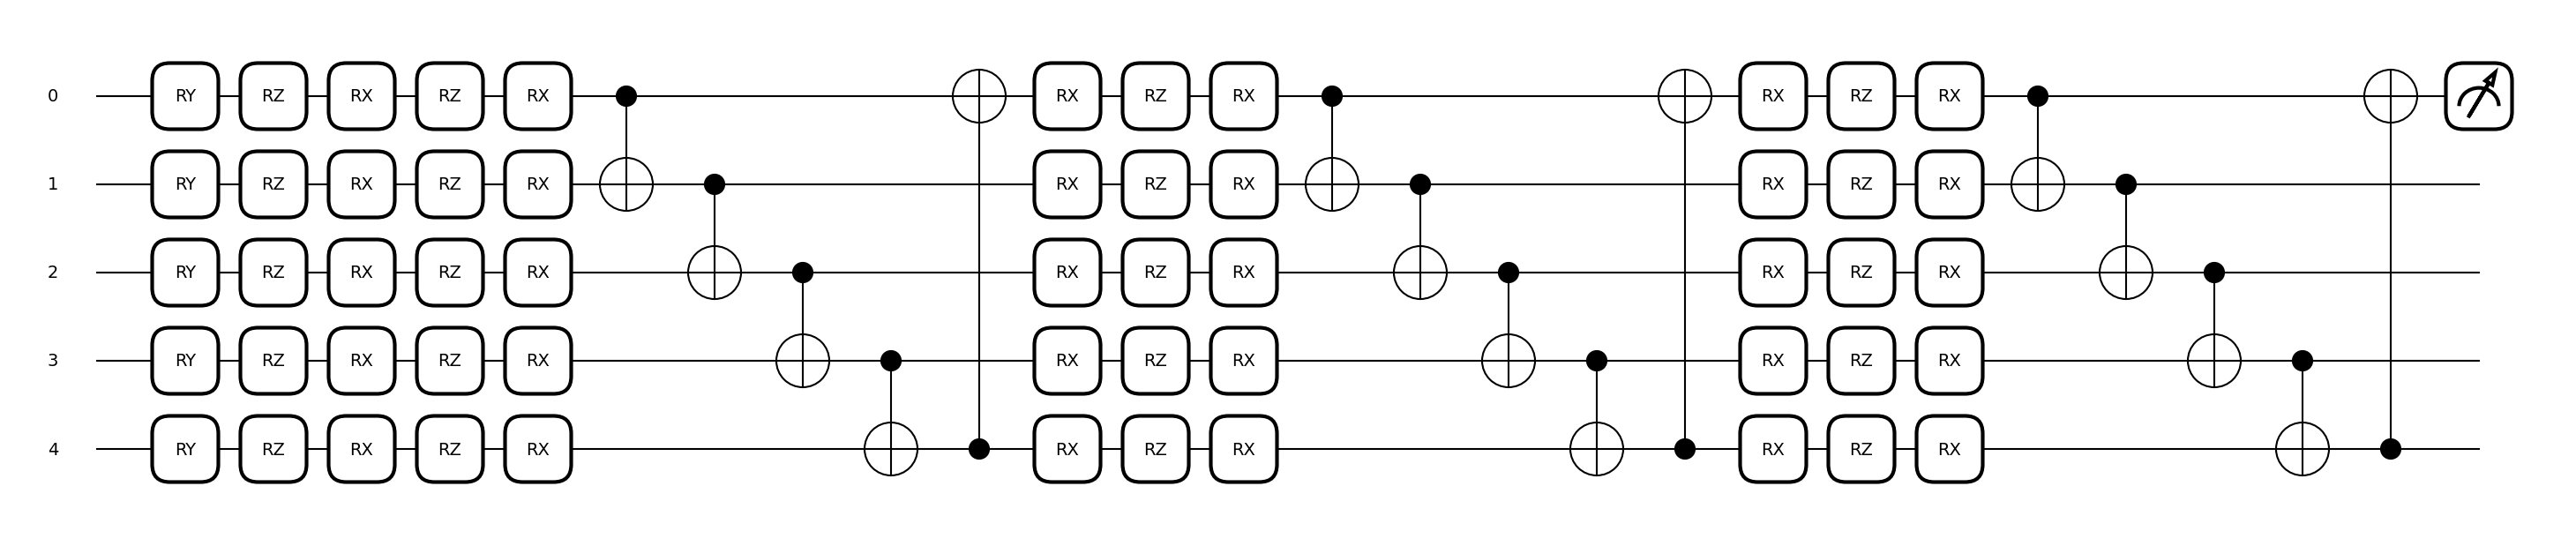

RUD 3
90 30
A2_HWE-CNOT AL_1 RUD_3
 wires: 5
gates: 90
depth: 30
shots: Shots(total=None)
gate_types:
{'RY': 15, 'RZ': 30, 'RX': 30, 'CNOT': 15}
gate_sizes:
{1: 75, 2: 15}


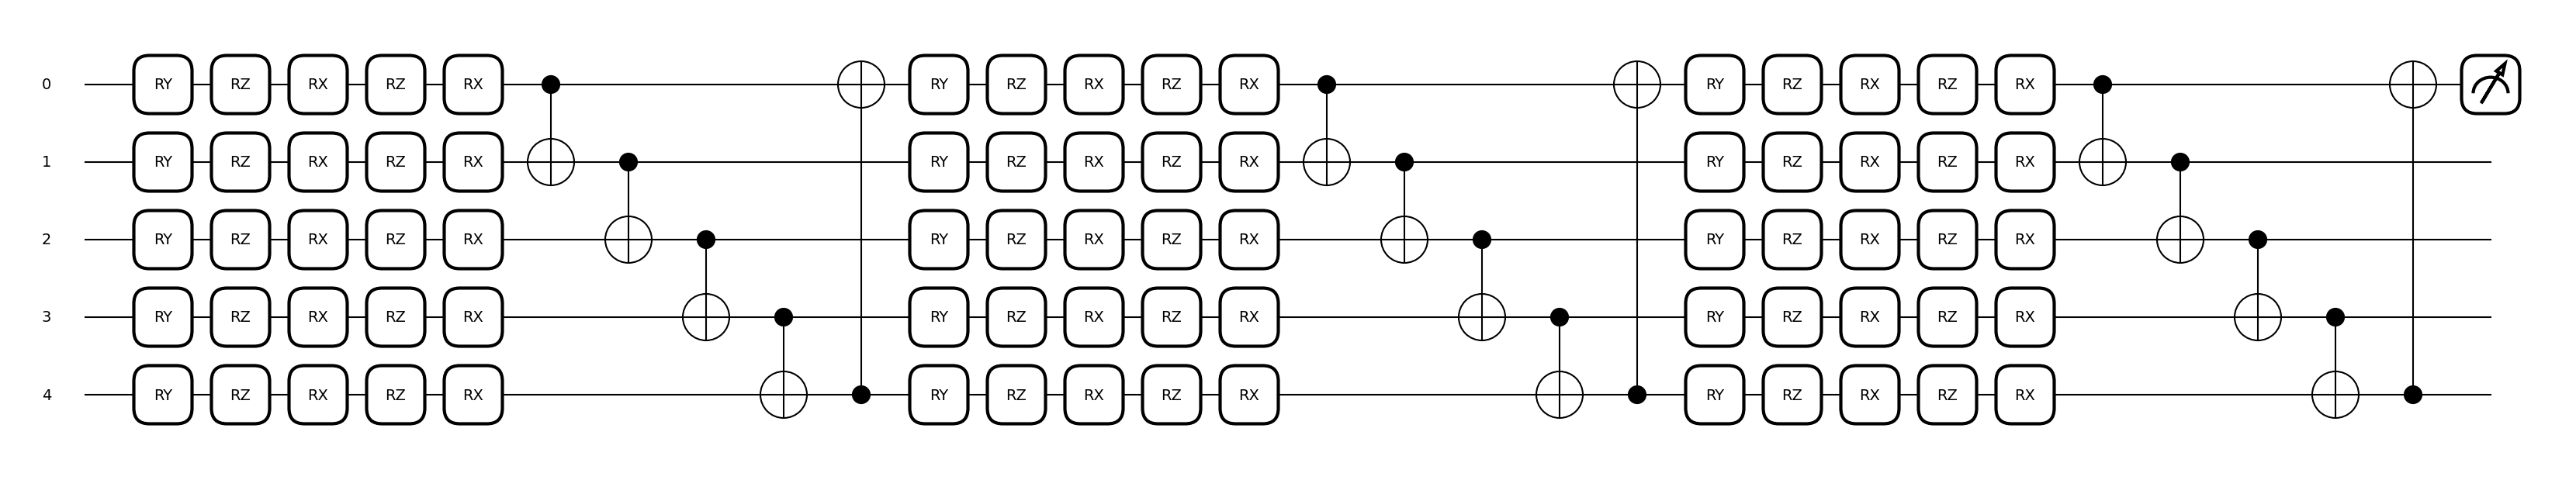

AL 5
110 42
A2_HWE-CNOT AL_5 RUD_1
 wires: 5
gates: 110
depth: 42
shots: Shots(total=None)
gate_types:
{'RY': 5, 'RZ': 30, 'RX': 50, 'CNOT': 25}
gate_sizes:
{1: 85, 2: 25}


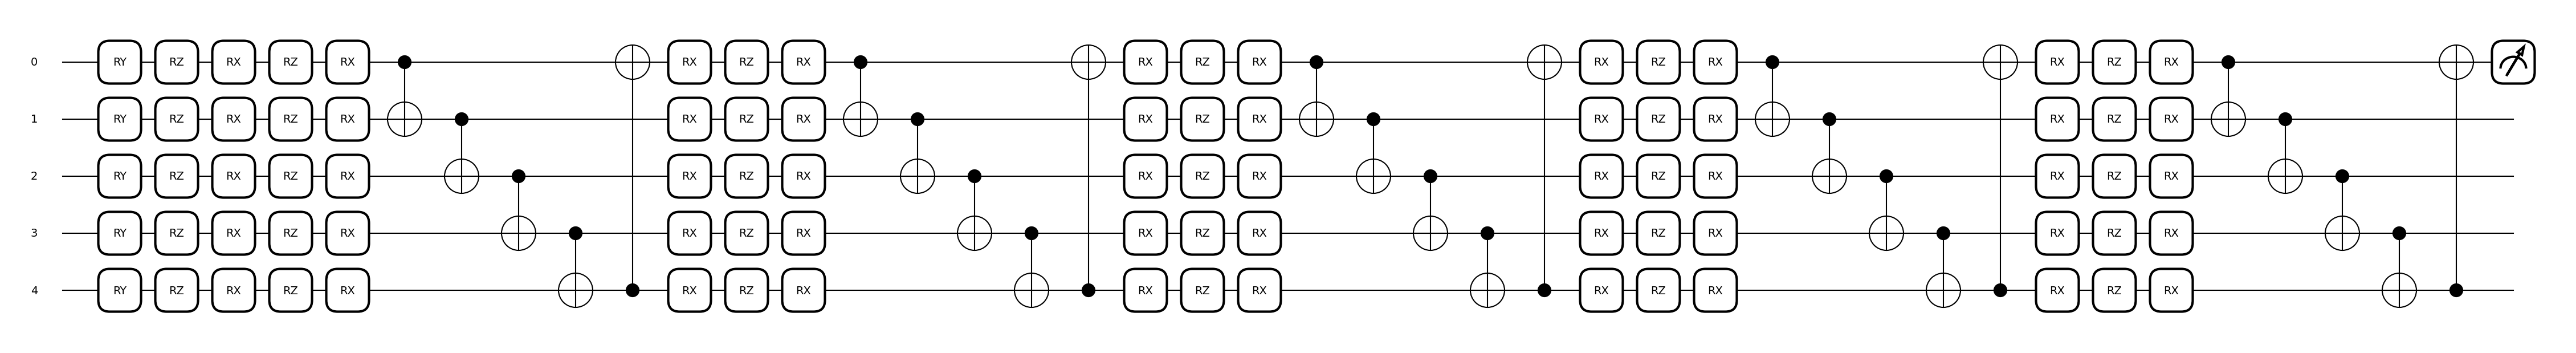

RUD 5
150 50
A2_HWE-CNOT AL_1 RUD_5
 wires: 5
gates: 150
depth: 50
shots: Shots(total=None)
gate_types:
{'RY': 25, 'RZ': 50, 'RX': 50, 'CNOT': 25}
gate_sizes:
{1: 125, 2: 25}


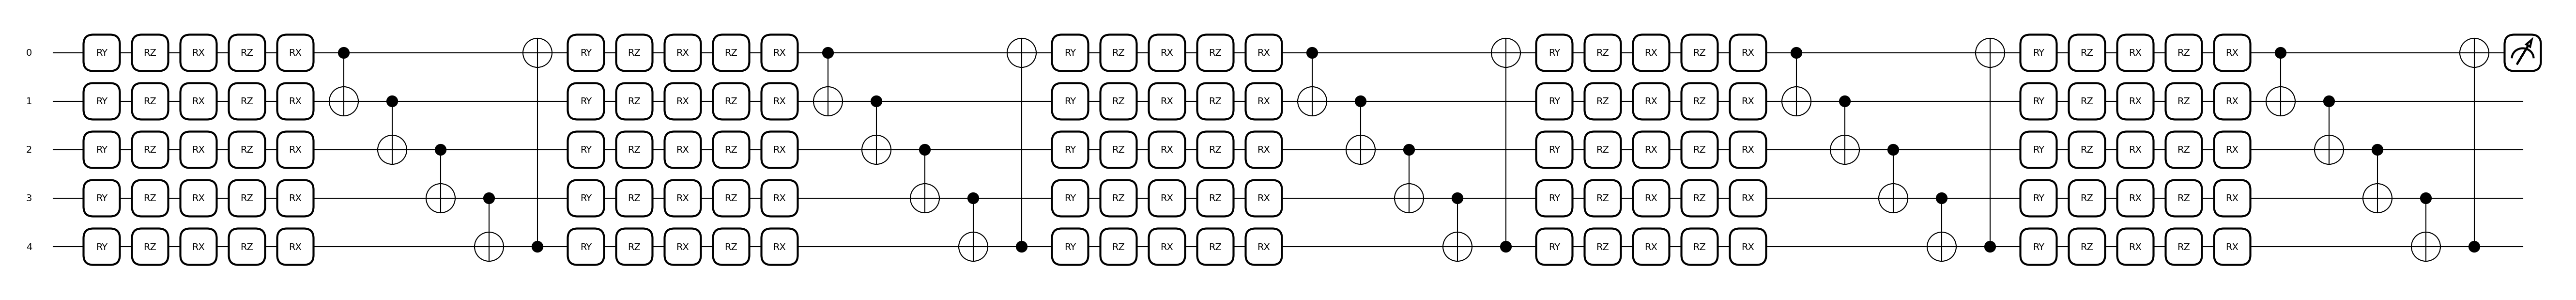

In [10]:
results={}
flat_results=[]
for d in [3, 5]:
    results[d]={}
    for a in ['AL','RUD']:
        results[d][a]={}
        print(a,d)
        if a=='AL':
            LAYERS=d
            re_upload_depth=1
        else:
            LAYERS=1
            re_upload_depth=d
            
        for p in ["A2_HWE-CNOT"]:
            results[d][a][p]={}
            depth_path = os.path.join("./",''.join((str(d),a)),p)
            if os.path.exists(depth_path):
                with open(os.path.join(depth_path,f'{p}_results.json'),'r') as f:
                    results_dict=json.load(f)
                
                
            ENCODER, ANSATZ = p.split('_')
            # print(ENCODER, ANSATZ)
            encoder = ENCODER_LIST[ENCODER]
            variational=ANSATZ_LIST[ANSATZ]
            variational.layers = LAYERS
            variational.set_wires(range(num_qubits))
     

            num_params = variational.num_params * re_upload_depth
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            feat = generator.uniform(-1, 1, num_qubits)
            
            qnode = qml.QNode(circuit, device)        
            circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']
            print(circuit_specs.num_gates,circuit_specs.depth)
            # print(circuit_gates,circuit_depth)
            print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
            qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
            plt.show()
            
            circuit_gates,circuit_depth= get_depth(encoder,variational,re_upload_depth,feat,initial_parameters)
            
            # print(variational.layers)
            # print()
            with open(os.path.join(depth_path,'model_log.csv'),'r') as f:
                # Create df
                timedf = pd.DataFrame(pd.to_datetime([i.split(',')[0] for i in f.readlines() if '[' in i], format='%a %b %d %H:%M:%S %Y'),columns=['Time'])
                # Get time between iterations and get the mean time
                timedf['Iter time']=[i.total_seconds() for i in timedf['Time'].diff()]
                

            results[d][a][p]={'R2_train':results_dict['R2_train'],'R2_test':results_dict['R2_test'],'num_gates':circuit_gates,'depth':circuit_depth,'mean_iter':timedf['Iter time'].mean()}
            if a=='AL':
                flat_results.append((d,1,p,results_dict['R2_train'],results_dict['R2_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))
            else:
                flat_results.append((1,d,p,results_dict['R2_train'],results_dict['R2_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))
            

In [11]:
for p in ["A2_HWE-CNOT"]:
    
    with open(os.path.join(HOME,f'qregress/qml_DDCC/5/{p}/{p}_results.json'),'r') as f:
        og_results=json.load(f)
        
    ENCODER, ANSATZ = p.split('_')
    # print(ENCODER, ANSATZ)
    encoder = ENCODER_LIST[ENCODER]
    variational=ANSATZ_LIST[ANSATZ]

    LAYERS=1
    re_upload_depth=1
    variational.layers = LAYERS
    variational.set_wires(range(num_qubits))
    

    num_params = variational.num_params * re_upload_depth
    generator = np.random.default_rng(12958234)
    initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
    feat = generator.uniform(-1, 1, num_qubits)
    
    qnode = qml.QNode(circuit, device)   

    # print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
    # qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
    # plt.show()
    
    circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']

    circuit_gates,circuit_depth= get_depth(encoder,variational,1,feat,initial_parameters)
    
    with open(os.path.join(HOME,f'qregress/qml_DDCC/5/{p}/','model_log.csv'),'r') as f:
        # Create df
        timedf = pd.DataFrame(pd.to_datetime([i.split(',')[0] for i in f.readlines() if '[' in i], format='%a %b %d %H:%M:%S %Y'),columns=['Time'])
        # Get time between iterations and get the mean time
        timedf['Iter time']=[i.total_seconds() for i in timedf['Time'].diff()]
    
    flat_results.append((1,1,p,og_results['R2_train'],og_results['R2_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))

In [12]:
df = pd.DataFrame(flat_results,columns=['AL','RUD','pairs','R2 Train','R2 Test','num_gates','depth','mean_iter'])

In [13]:
df.sort_values(by=['R2 Train','R2 Test'])

,AL,RUD,pairs,R2 Train,R2 Test,num_gates,depth,mean_iter
4,1,1,A2_HWE-CNOT,0.619124,0.618428,30,10,54.601602
0,3,1,A2_HWE-CNOT,0.712055,0.714193,70,26,NaN
2,5,1,A2_HWE-CNOT,0.772462,0.773425,110,42,NaN
3,1,5,A2_HWE-CNOT,0.821199,0.826484,150,50,NaN
1,1,3,A2_HWE-CNOT,0.846314,0.847447,90,30,683.512000


In [14]:
df['diff']=(df['R2 Train']-df['R2 Test']).abs()

In [15]:
base = df[(df["AL"]==1)&(df["RUD"]==1)]['R2 Train']

In [16]:
df[(df["AL"]!=1)|(df["RUD"]!=1)]

,AL,RUD,pairs,R2 Train,R2 Test,num_gates,depth,mean_iter,diff
0,3,1,A2_HWE-CNOT,0.712055,0.714193,70,26,NaN,0.002138
1,1,3,A2_HWE-CNOT,0.846314,0.847447,90,30,683.512,0.001133
2,5,1,A2_HWE-CNOT,0.772462,0.773425,110,42,NaN,0.000963
3,1,5,A2_HWE-CNOT,0.821199,0.826484,150,50,NaN,0.005285


In [17]:
df.sort_values(by=['R2 Train','R2 Test'])

,AL,RUD,pairs,R2 Train,R2 Test,num_gates,depth,mean_iter,diff
4,1,1,A2_HWE-CNOT,0.619124,0.618428,30,10,54.601602,0.000696
0,3,1,A2_HWE-CNOT,0.712055,0.714193,70,26,NaN,0.002138
2,5,1,A2_HWE-CNOT,0.772462,0.773425,110,42,NaN,0.000963
3,1,5,A2_HWE-CNOT,0.821199,0.826484,150,50,NaN,0.005285
1,1,3,A2_HWE-CNOT,0.846314,0.847447,90,30,683.512000,0.001133


In [18]:
100*((df[(df["AL"]!=1)|(df["RUD"]!=1)]['R2 Train'] - base.values)/base.values)

0    15.010154
1    36.695367
2    24.766982
3    32.638865
Name: R2 Train, dtype: float64

In [19]:
df['AL_RUD']=[f"({AL},{RUD})" for AL,RUD in df[['AL','RUD']].values]

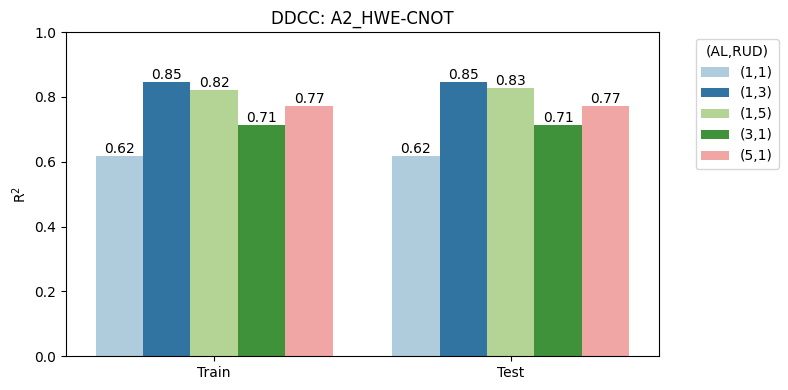

In [20]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=df.rename(columns={'R2 Train':'Train','R2 Test':'Test'}).melt(id_vars=['AL_RUD'], value_vars=['Train','Test']).sort_values(by='AL_RUD'),x='variable',y='value',hue='AL_RUD',palette=sns.color_palette('Paired',5))
for bar in ax.patches:
    height = bar.get_height()
    if height!=0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',  # Format the label as desired
            ha='center',
            va='bottom',

        )
plt.ylabel('R$^{2}$ ')
plt.xlabel('')
plt.title('DDCC: A2_HWE-CNOT')
plt.legend(bbox_to_anchor=(1.05, 1.0),title='(AL,RUD)')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(os.path.join(HOME,'qregress/images/DDCC/','DDCC_RUDAL.png'),dpi=300,bbox_inches='tight')
plt.show()

In [21]:
median_Train,median_Test=np.median(df[['R2 Train',"R2 Test"]].values,axis=0)

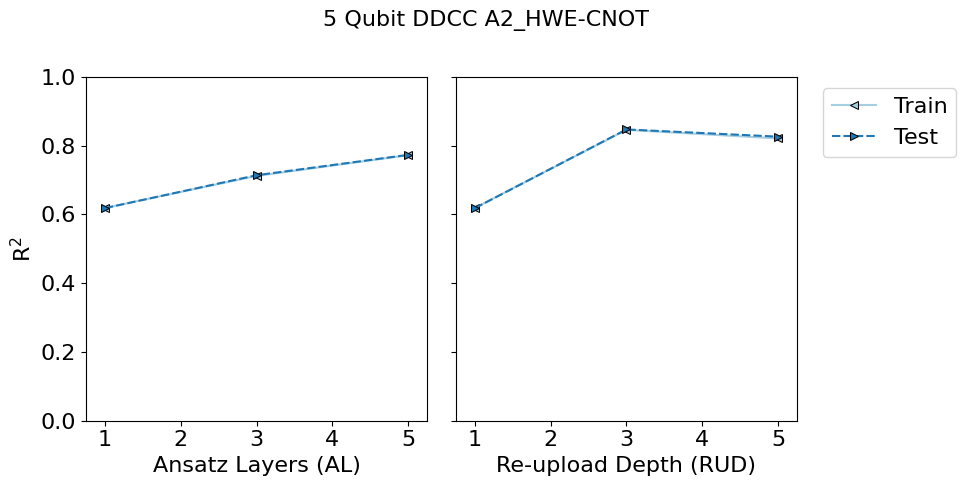

In [22]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

melteddf = df.rename(columns={'R2 Train':'Train','R2 Test':'Test'}).melt(id_vars=['AL','RUD'], value_vars=['Train','Test'])

fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.lineplot(melteddf[melteddf['RUD']==1],x='AL',y='value',hue='variable',ax=ax1,palette=sns.color_palette('Paired',2),markers=['<','>'], markeredgecolor='black',style='variable')
sns.lineplot(melteddf[melteddf['AL']==1],x='RUD',y='value',hue='variable',ax=ax2,palette=sns.color_palette('Paired',2),markers=['<','>'], markeredgecolor='black',style='variable')
ax1.set_ylim(0,1)
ax1.set_ylabel("R$^{2}$")
ax1.set_xlim(0.75,5.25)
ax2.set_xlim(0.75,5.25)
ax1.set_xlabel("Ansatz Layers (AL)")
ax2.set_xlabel("Re-upload Depth (RUD)")
# Remove legends from individual plots
ax1.get_legend().remove()
ax2.get_legend().remove()

# Global legend
fig.suptitle('5 Qubit DDCC A2_HWE-CNOT')
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1.0))
plt.tight_layout()
plt.savefig(os.path.join(HOME,'qregress/images/DDCC/','DDCC_RUDAL_lineplot.png'),dpi=300,bbox_inches='tight')
plt.show()

In [23]:
palette=sns.color_palette('Paired',4)

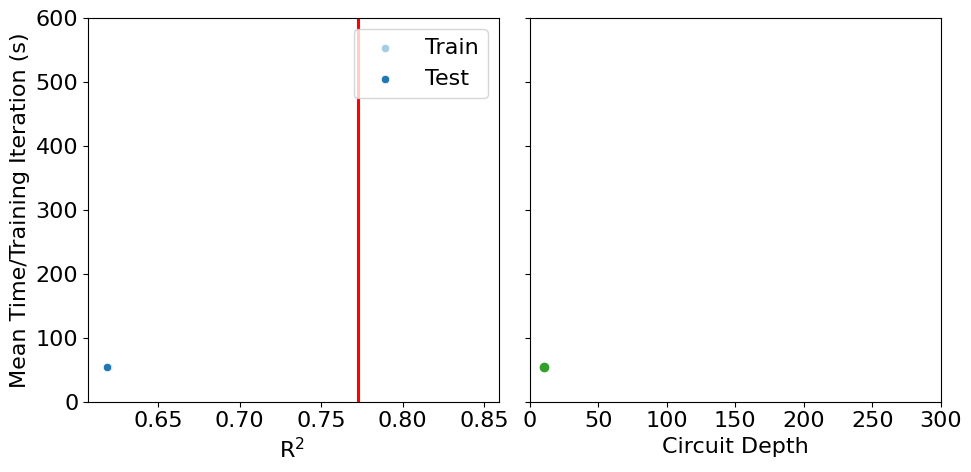

In [24]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.scatterplot(df,x='R2 Train',y='mean_iter',label='Train',ax=ax[0],color=palette[0])
sns.scatterplot(df,x='R2 Test',y='mean_iter',label='Test',ax=ax[0],color=palette[1])
# plt.hlines(df.describe().loc['mean','mean_iter'],0,50)
ax[0].hlines(np.median(df['mean_iter']),0,50)
ax[0].vlines(median_Train,0,700,color='r')
ax[0].vlines(median_Test,0,700,color='r')

# ax[0].set_xlim(15,45)
ax[0].set_ylim(0,600)
ax[0].set_ylabel('Mean Time/Training Iteration (s)')
ax[0].set_xlabel('R$^{2}$ ')
ax[0].legend()

ax[1].scatter(df['depth'],df['mean_iter'],color=palette[3])
ax[1].set_xlim(0,300)
ax[1].set_xlabel('Circuit Depth')
plt.tight_layout()
# plt.savefig('DDCC_circuitdepth_R2_vs_iterationtime.png',dpi=300,bbox_inches='tight')
plt.show()

NameError: name 'pairs' is not defined

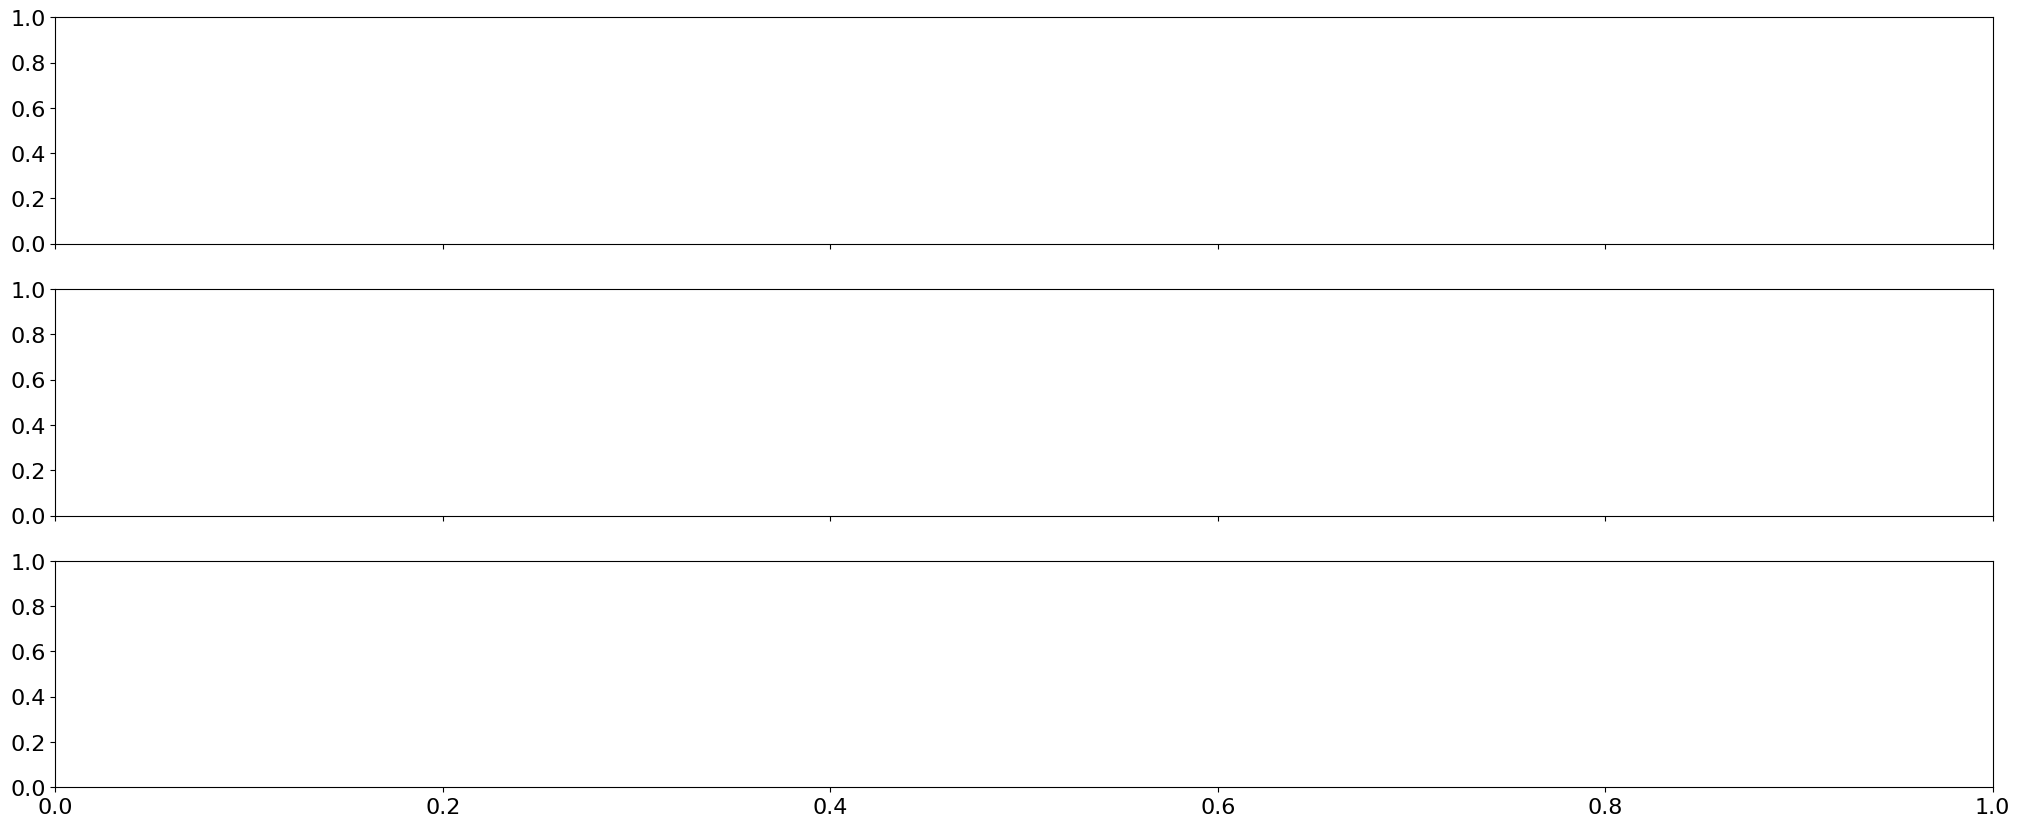

In [25]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig,ax=plt.subplots(3,5//3,sharey=True,sharex=True,figsize=(25,10))


for idxe,p in enumerate(pairs):
    
        pairdf=df[df['pairs']==p].sort_values(by=["num_gates"])
        min=pairdf.sort_values(by=['R2 Train',"R2 Test"]).iloc[0]
        ax[idxe%3,idxe%5].plot(pairdf['num_gates'],pairdf['R2 Train'],label=f'Train'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[1])
        ax[idxe%3,idxe%5].plot(pairdf['num_gates'],pairdf['R2 Test'],label=f'Test'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[3])
        ax[idxe%3,idxe%5].scatter(min['num_gates'],min['R2 Train'],color=palette[1])
        ax[idxe%3,idxe%5].scatter(min['num_gates'],min['R2 Test'],color=palette[3])
        ax[idxe%3,idxe%5].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train R2")
        ax[idxe%3,idxe%5].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test R2")
        ax[idxe%3,idxe%5].legend(ax[idxe%3,idxe%5].get_legend_handles_labels()[0][:-2],ax[idxe%3,idxe%5].get_legend_handles_labels()[1][:-2],loc=1)
        ax[idxe%3,idxe%5].set_ylabel('R$^{2}$ ')
        ax[idxe%3,idxe%5].set_xlim(0,450)
        ax[idxe%3,idxe%5].set_title(p)

        if (idxe%3)==2:
            ax[idxe%3,idxe%5].set_xlabel('Number of Gates')

fig.legend(ax[-1,-1].get_legend_handles_labels()[0][-2:],ax[-1,-1].get_legend_handles_labels()[1][-2:], loc='right', bbox_to_anchor=(1.11, 0.9))        
plt.tight_layout()        
# plt.savefig('DDCC_numgates_vs_R2.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig,ax=plt.subplots(3,len(pairs)//3,sharey=True,sharex=True,figsize=(25,10))


for idxe,p in enumerate(pairs):
    
        pairdf=df[df['pairs']==p].sort_values(by=["depth"])
        min=pairdf.sort_values(by=['R2 Train',"R2 Test"]).iloc[0]
        ax[idxe%3,idxe%5].plot(pairdf['depth'],pairdf['R2 Train'],label=f'Train'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[1])
        ax[idxe%3,idxe%5].plot(pairdf['depth'],pairdf['R2 Test'],label=f'Test'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[3])
        ax[idxe%3,idxe%5].scatter(min['depth'],min['R2 Train'],color=palette[1])
        ax[idxe%3,idxe%5].scatter(min['depth'],min['R2 Test'],color=palette[3])
        ax[idxe%3,idxe%5].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train R2")
        ax[idxe%3,idxe%5].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test R2")
        ax[idxe%3,idxe%5].legend(ax[idxe%3,idxe%5].get_legend_handles_labels()[0][:-2],ax[idxe%3,idxe%5].get_legend_handles_labels()[1][:-2],loc=1)
        ax[idxe%3,idxe%5].set_ylabel('R$^{2}$ ')
        ax[idxe%3,idxe%5].set_xlim(0,200)
        ax[idxe%3,idxe%5].set_title(p)

        if (idxe%3)==2:
            ax[idxe%3,idxe%5].set_xlabel('Circuit Depth')

fig.legend(ax[-1,-1].get_legend_handles_labels()[0][-2:],ax[-1,-1].get_legend_handles_labels()[1][-2:], loc='right', bbox_to_anchor=(1.1, 0.9))                
plt.tight_layout()        
plt.savefig('DDCC_circuitdepth_vs_R2.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# SMALL_SIZE = 8
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 12

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# fig,ax=plt.subplots(2,len(ENCODERs)//2,sharey=True,sharex=True,figsize=(25,10))

# for idxa,a in enumerate(ANSATZs):
#     for idxe,e in enumerate(ENCODERs):
#         if '_'.join((a,e)) in pairs:
#             pairdf=df[df['pairs']=='_'.join((a,e))].sort_values(by=["num_gates"])
#             min=pairdf.sort_values(by=['R2 Train',"R2 Test"]).iloc[0]
#             ax[idxe%2,idxe%5].plot(pairdf['num_gates'],pairdf['R2 Train'],label=f'Train {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].plot(pairdf['num_gates'],pairdf['R2 Test'],label=f'Test {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].scatter(min['num_gates'],min['R2 Train'])
#             ax[idxe%2,idxe%5].scatter(min['num_gates'],min['R2 Test'])
#             ax[idxe%2,idxe%5].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train R2")
#             ax[idxe%2,idxe%5].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test R2")
#             ax[idxe%2,idxe%5].legend(loc=2)
#             ax[idxe%2,idxe%5].set_ylabel(e)
#             ax[idxe%2,idxe%5].set_xlim(0,450)

#             if (idxe%2)==1:
#                 ax[idxe%2,idxe%5].set_xlabel('Number of Gates')
    
        
# plt.tight_layout()        
# plt.show()

In [ ]:
# fig,ax=plt.subplots(2,len(ENCODERs)//2,sharey=True,sharex=True,figsize=(25,10))

# for idxa,a in enumerate(ANSATZs):
#     for idxe,e in enumerate(ENCODERs):
#         if '_'.join((a,e)) in pairs:
#             pairdf=df[df['pairs']=='_'.join((a,e))].sort_values(by=["depth"])
#             min=pairdf.sort_values(by=['R2 Train',"R2 Test"]).iloc[0]
#             ax[idxe%2,idxe%5].plot(pairdf['depth'],pairdf['R2 Train'],label=f'Train {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].plot(pairdf['depth'],pairdf['R2 Test'],label=f'Test {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].scatter(min['depth'],min['R2 Train'])
#             ax[idxe%2,idxe%5].scatter(min['depth'],min['R2 Test'])
#             ax[idxe%2,idxe%5].hlines(median_Train,-10,300,color='r',linestyles=':',label="Median Train R2")
#             ax[idxe%2,idxe%5].hlines(median_Test,-10,300,color='b',linestyles=':',label="Median Test R2")
#             ax[idxe%2,idxe%5].legend(loc=2)
#             ax[idxe%2,idxe%5].set_ylabel(e)
#             ax[idxe%2,idxe%5].set_xlim(0,200)

#             if (idxe%2)==1:
#                 ax[idxe%2,idxe%5].set_xlabel('Circuit Depth')
    
        
# plt.tight_layout()        
# plt.show()

In [ ]:
# for p in pairs:
#     sns.lineplot(df[df['pairs']==p].melt(id_vars=['num_gates','depth'],value_vars=['R2 Train','R2 Test']),x='depth',y='value',hue='variable')
#     plt.show()

In [ ]:
layerdf=df.melt(id_vars=['AL','RUD'],value_vars=['R2 Train','R2 Test'])

In [ ]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.boxplot(data=layerdf,y='value',hue='variable',x='AL',ax=ax[0],palette=sns.color_palette('Paired',2))
sns.boxplot(data=layerdf,y='value',hue='variable',x='RUD',ax=ax[1],palette=sns.color_palette('Paired',2))
# ax[0].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train R2")
# ax[0].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test R2")
# ax[1].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train R2")
# ax[1].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test R2")
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
ax[0].set_xlim(-0.5,2.5)
ax[1].set_xlim(-0.5,2.5)
ax[0].set_ylim(15,45)
ax[1].set_ylim(15,45)
ax[0].set_ylabel('R$^{2}$ ')
ax[0].set_xlabel('Ansatz Layers')
ax[1].set_xlabel('Re-upload Depth')
fig.legend(ax[1].get_legend_handles_labels()[0],ax[1].get_legend_handles_labels()[1], loc='right', bbox_to_anchor=(1.2, 0.9))                
plt.tight_layout()
plt.savefig('DDCC_R2_vs_layers.png',dpi=300,bbox_inches='tight')
plt.show()